In [34]:
# Importing libraries
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
import xgboost
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from math import sqrt
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
# Importing dataset to pandas dataframe
df = pd.read_csv('Metro_Interstate_Traffic_Volume.csv')


In [35]:
df_clean = df.copy()
# converting holiday to boolean 0 and 1 for initial analysis
df_clean['holiday'] = np.where(df_clean['holiday'] == 'None', 0, 1)
df_clean['holiday'].astype("category")
df_clean.rename(columns = {'weather_main':'weather'}, inplace = True) #renaming for convention purpose
df_clean['weather'].astype("category")
df_clean.drop('weather_description', axis = 1, inplace = True) #dropping weather description as it's redundant
#df_clean['temp'] = (df_clean['temp'] - 273.15) #converting kelvin to celsius
df_clean = df_clean[df_clean['temp'] >= 213.15] # filtering out outliers as recorded lowest temp in MN, USA is 233.15 C
df_clean = df_clean[df_clean['rain_1h'] < 232] #filtering out outliers as recorded highest rainfall in MN, USA is 23 MM
df_clean['date_time'] = pd.to_datetime(df_clean['date_time']) #converting datetime string to datetime datatype
df_clean['month'] = df_clean['date_time'].dt.month  # adding a month column
df_clean['month'].astype("category")
# adding a column for day of the week
df_clean['weekday'] = df_clean['date_time'].dt.dayofweek
df_clean['weekday'].astype("category")
# adding a column for hour of the day
df_clean['hour'] = df_clean['date_time'].dt.hour
df_clean['hour'].astype("category")
df_clean = df_clean.groupby('date_time').first() # removing duplicate date_time


In [36]:
scaler = MinMaxScaler()
scaler.fit(df_clean[['temp', 'rain_1h', 'clouds_all', 'snow_1h']])
df_clean[['temp', 'rain_1h', 'clouds_all', 'snow_1h']] = scaler.transform(df_clean[['temp', 'rain_1h', 'clouds_all', 'snow_1h']])


Previous regession methods of Linear, KNN, and Decision did not give good or usable results that could be used to predict traffic volume therefore I will be conducting alternative algorithm. I will be conduction Time-Series Analysis using XGBoost and see if this method will return better results than the three initial proposed methods.

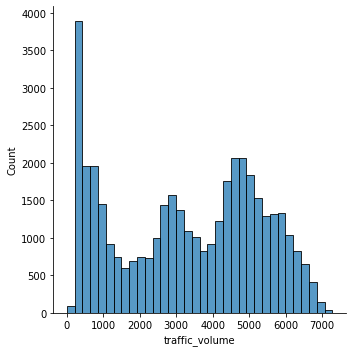

In [37]:
sb.displot(df_clean['traffic_volume']) #histogram of Traffic Volume


In [38]:
df_clean.index

DatetimeIndex(['2012-10-02 09:00:00', '2012-10-02 10:00:00',
               '2012-10-02 11:00:00', '2012-10-02 12:00:00',
               '2012-10-02 13:00:00', '2012-10-02 14:00:00',
               '2012-10-02 15:00:00', '2012-10-02 16:00:00',
               '2012-10-02 17:00:00', '2012-10-02 18:00:00',
               ...
               '2018-09-30 14:00:00', '2018-09-30 15:00:00',
               '2018-09-30 16:00:00', '2018-09-30 17:00:00',
               '2018-09-30 18:00:00', '2018-09-30 19:00:00',
               '2018-09-30 20:00:00', '2018-09-30 21:00:00',
               '2018-09-30 22:00:00', '2018-09-30 23:00:00'],
              dtype='datetime64[ns]', name='date_time', length=40564, freq=None)

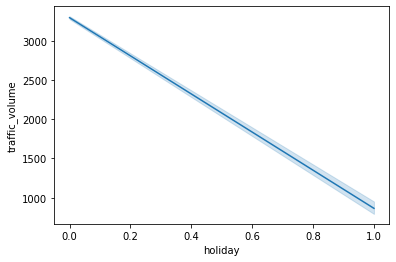

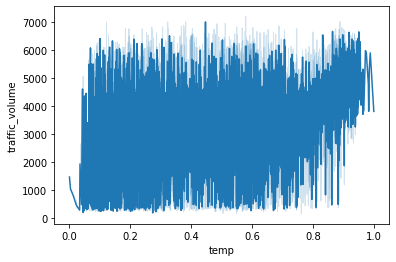

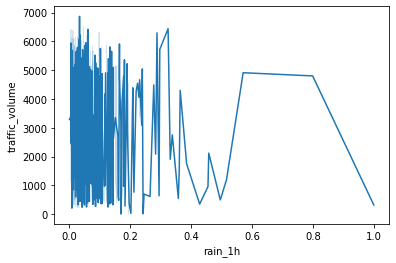

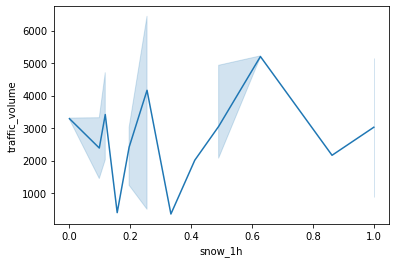

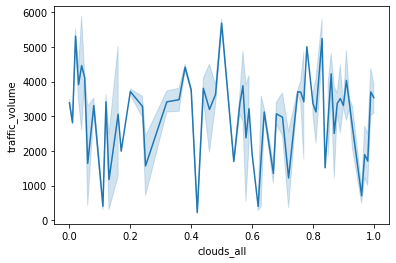

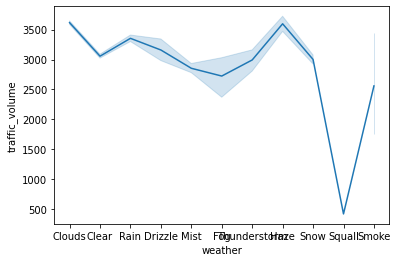

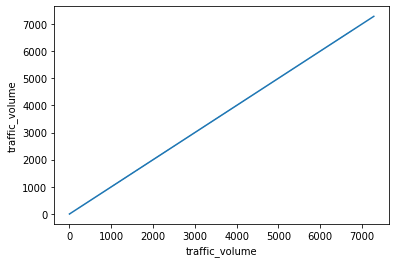

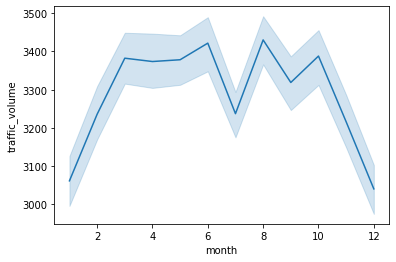

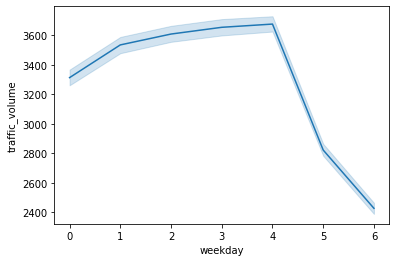

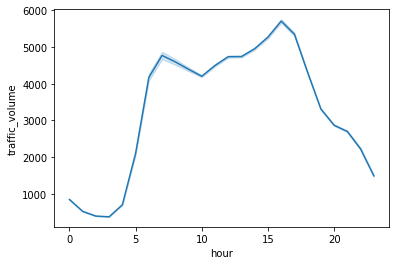

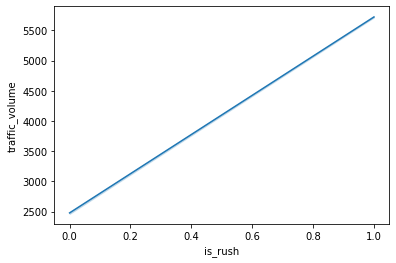

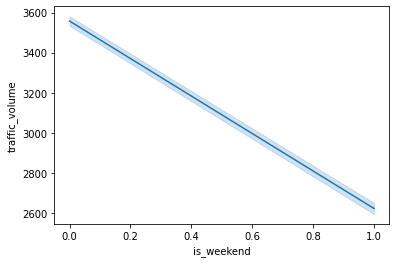

In [50]:
for feature in df_clean.columns:
    sb.lineplot(data=df_clean, x=feature, y='traffic_volume', estimator="mean",
                    palette='RdBu')
    plt.show()


count    40564.000000
mean      3291.081402
std       1984.638849
min          0.000000
25%       1249.750000
50%       3429.000000
75%       4952.000000
max       7280.000000
Name: traffic_volume, dtype: float64

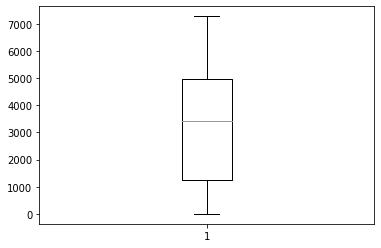

In [40]:
plt.boxplot(df_clean['traffic_volume'])
df_clean['traffic_volume'].describe()


In [41]:
# creating new column based on traffic volume dividing into three sections of high, normal, and low traffic.
high = df_clean['traffic_volume'].quantile(.75)
df_clean['is_rush'] = np.where(df_clean['traffic_volume'] >= high, 1, 0)
df_clean['is_rush'].astype('category')
#df_clean['traffic_rate'] = np.where(
    #df_clean['traffic_volume'] >= normal, "normal", "low")

# creating new column to mark is it a weekend day or not
df_clean['is_weekend'] = np.where((df_clean['weekday'] == 5) | (df_clean['weekday']==6), 1, 0) # Saturday represented with a 5 and Sunday with a 6
df_clean['is_weekend'].astype('category')


date_time
2012-10-02 09:00:00    0
2012-10-02 10:00:00    0
2012-10-02 11:00:00    0
2012-10-02 12:00:00    0
2012-10-02 13:00:00    0
                      ..
2018-09-30 19:00:00    1
2018-09-30 20:00:00    1
2018-09-30 21:00:00    1
2018-09-30 22:00:00    1
2018-09-30 23:00:00    1
Name: is_weekend, Length: 40564, dtype: category
Categories (2, int64): [0, 1]

<AxesSubplot:>

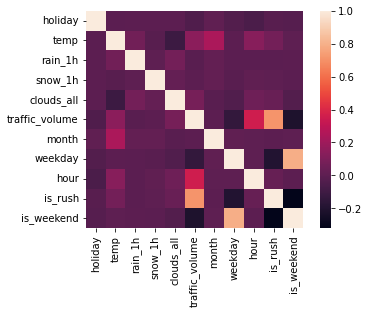

In [42]:
corrmat = df_clean.corr()
f, ax = plt.subplots()
sb.heatmap(corrmat,square='True')

In [43]:
X = df_clean.drop(["traffic_volume"],
                  axis=1).copy()  # independent variables
Y = df_clean['traffic_volume'].copy() # dependent variables
#X_OHE = pd.get_dummies(X, columns=['weather']) # One Hot Encoding for Dummy Variables

In [44]:
# splitting dataset into training, test, and validation
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(
    X, Y, test_size=.15, shuffle=False)


In [45]:
# initializing XGBoost

reg = xgboost.XGBRegressor(max_depth=8, learning_rate=0.03, gamma=0.001, reg_lambda=0,
                           reg_alpha=0.09565, n_estimators=500, n_thread=24, tree_method="gpu_hist", enable_categorical=True, use_label_encoder=False)



In [46]:

cat_attribs = ['holiday', 'weather', 'is_rush', 'is_weekend', 'month', 'weekday', 'hour']
full_pipeline = ColumnTransformer([('cat', OneHotEncoder(
    handle_unknown='ignore'), cat_attribs)], remainder='passthrough')

encoder = full_pipeline.fit(x_train)
x_train = encoder.transform(x_train)
x_test = encoder.transform(x_test)

reg.fit(x_train, y_train)


[11:32:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "n_thread" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=True,
             eval_metric=None, gamma=0.001, gpu_id=0, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.03, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=8, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=500, n_jobs=0,
             n_thread=24, num_parallel_tree=1, predictor='auto', random_state=0,
             reg_alpha=0.09565, ...)

In [47]:
# XGBoost predict

predictions_xgb = reg.predict(x_test)
rmse = sqrt(mean_squared_error(y_test, predictions_xgb))
mse = mean_absolute_error(y_test, predictions_xgb)
rs = r2_score(y_test, predictions_xgb)
print("R Squared (R2): %.3f" % rs)
print("Root Mean Square Error (RMSE): %.3f" % rmse)
print("Mean Absolute Error (MAE): %.3f" % mse)


R Squared (R2): 0.964
Root Mean Square Error (RMSE): 375.767
Mean Absolute Error (MAE): 229.020


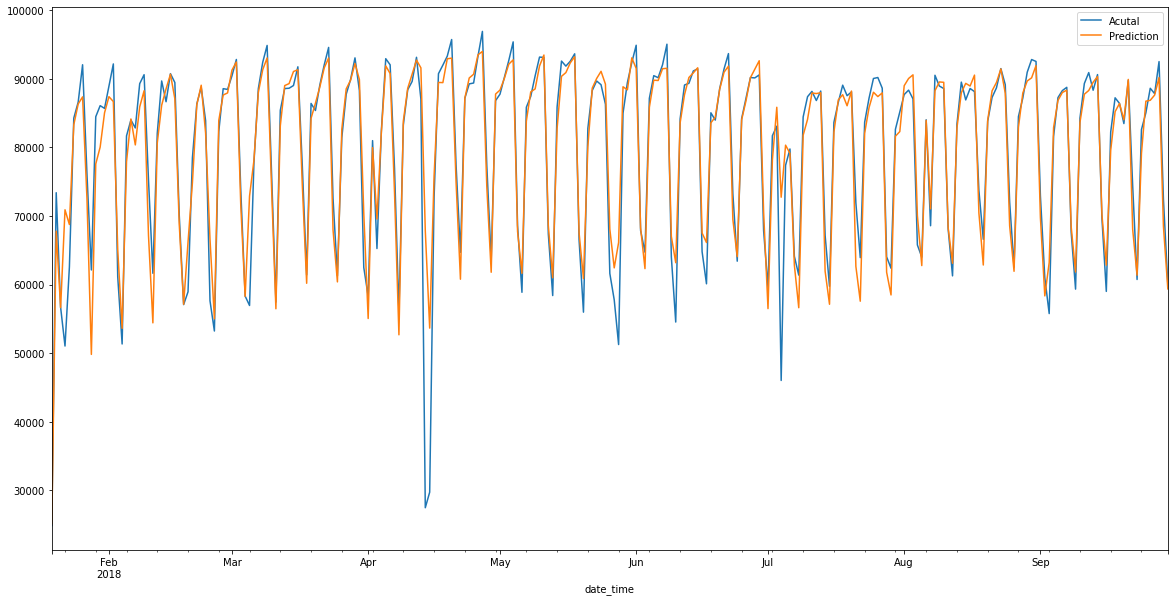

In [48]:
#y_test.plot(figsize=(25,10))
#results.plot()
results = pd.DataFrame(predictions_xgb)
results.index = y_test.index
ax = y_test.resample('D').sum().plot(figsize=(20,10))
results.resample('D').sum().plot(ax=ax, )
ax.legend(["Acutal", "Prediction"])
#ax = y_test.plot(figsize=(30,10))
#results.plot(ax=ax)